In [1]:
import argparse
import time
import numpy as np
from math import ceil
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn.functional as F
from torch import optim

# from model import RW_NN
from utils import load_data, generate_batches, accuracy, AverageMeter

In [ ]:
# settings
from types import SimpleNamespace
args = SimpleNamespace(
    dataset='synthetic',
    use_node_labels=False,
    lr=1e-2,
    dropout=0.2,
    batch_size=64,
    epochs=200,
    hidden_graphs=16,
    size_hidden_graphs=5,
    hidden_dim=4,
    penultimate_dim=32,
    max_step=2,
    normalize=False,
)

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import random

open("graph_A.txt", "w").close()

open("graph_indicator.txt", "w").close()
open("graph_labels.txt", "w").close()
graph_indicator = 1
random_num = random.randint(5, 30)
random_graphs = []
for _ in range(25):
    n = random_num  # 10 nodes
    m = random_num  # 20 edges
    # seed = 42  # seed random number generators for reproducibility

    # Use seed for reproducibility
    G = nx.gnm_random_graph(n, m)
    random_graphs.append(G)
    # some properties
    # print("node degree clustering")
    # for v in nx.nodes(G):
    #     print(f"{v} {nx.degree(G, v)} {nx.clustering(G, v)}")

    # print()
    print(nx.generate_adjlist(G))
    pairs = []

    for line in nx.generate_adjlist(G):
        # Split the line into nodes
        nodes = line.split()
        # The first node is the source, and the rest are target
        source = nodes[0]
        targets = nodes[1:]
        
        # Generate (source, target) pairs
        for target in targets:
            print(str(int(source) + 1))
            pairs.append((str(int(source) + 1), str(int(target) + 1)))
    print(pairs)
    # Write the result to a file
    with open("graph_A.txt", "a") as f:
        for pair in pairs:
            f.write(f"{pair[0]}, {pair[1]}\n")

    with open("graph_indicator.txt", "a") as f:
        for pair in pairs:
            f.write(f"{graph_indicator}\n")
    with open("graph_labels.txt", "a") as f:
        f.write(f"0\n")
        graph_indicator += 1

<generator object generate_adjlist at 0x00000220FFE8A620>
1
1
2
2
2
3
3
4
4
4
6
6
8
8
10
12
13
13
[('1', '12'), ('1', '6'), ('2', '16'), ('2', '17'), ('2', '12'), ('3', '5'), ('3', '14'), ('4', '17'), ('4', '7'), ('4', '11'), ('6', '14'), ('6', '15'), ('8', '14'), ('8', '13'), ('10', '13'), ('12', '14'), ('13', '14'), ('13', '16')]
<generator object generate_adjlist at 0x00000220FFE8A620>
1
2
2
2
3
3
4
4
4
6
7
7
7
9
9
13
14
15
[('1', '13'), ('2', '17'), ('2', '12'), ('2', '14'), ('3', '5'), ('3', '18'), ('4', '6'), ('4', '12'), ('4', '11'), ('6', '14'), ('7', '8'), ('7', '15'), ('7', '14'), ('9', '14'), ('9', '18'), ('13', '16'), ('14', '17'), ('15', '17')]
<generator object generate_adjlist at 0x00000220FFE8A620>
1
1
1
3
4
5
5
8
8
8
8
9
10
12
12
13
15
17
[('1', '2'), ('1', '15'), ('1', '12'), ('3', '14'), ('4', '7'), ('5', '16'), ('5', '18'), ('8', '9'), ('8', '17'), ('8', '15'), ('8', '10'), ('9', '15'), ('10', '16'), ('12', '13'), ('12', '18'), ('13', '17'), ('15', '17'), ('17', '18

In [111]:
import matplotlib.pyplot as plt
import networkx as nx
import random
   
random_num = random.randint(5, 30)
random_graphs = []
for _ in range(25):
    n = random_num  # 10 nodes
    m = random_num  # 20 edges
    # seed = 42  # seed random number generators for reproducibility

    # Use seed for reproducibility
    G = nx.cycle_graph(n)
    random_graphs.append(G)
    # some properties
    # print("node degree clustering")
    # for v in nx.nodes(G):
    #     print(f"{v} {nx.degree(G, v)} {nx.clustering(G, v)}")

    # print()
    pairs = []

    for line in nx.generate_adjlist(G):
        # Split the line into nodes
        nodes = line.split()
        # The first node is the source, and the rest are targets
        source = nodes[0]
        targets = nodes[1:]
        
        # Generate (source, target) pairs
        for target in targets:
            pairs.append((str(int(source) + 1), str(int(target) + 1)))
        
    # Write the result to a file
    with open("graph_A.txt", "a") as f:
        for pair in pairs:
            f.write(f"{pair[0]}, {pair[1]}\n")
    with open("graph_indicator.txt", "a") as f:
        for pair in pairs:
            f.write(f"{graph_indicator}\n")
    with open("graph_labels.txt", "a") as f:
        f.write(f"1\n")
        graph_indicator += 1

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [5]:
adj_lst, features_lst, class_labels = load_data(args.dataset, args.use_node_labels)

N = len(adj_lst)
features_dim = features_lst[0].shape[1]

enc = LabelEncoder()
class_labels = enc.fit_transform(class_labels)
n_classes = np.unique(class_labels).size
y = [np.array(class_labels[i]) for i in range(class_labels.size)]

kf = KFold(n_splits=10, shuffle=True, random_state=13)
it = 0
accs = list()

In [ ]:
# THE MODEL
import torch
import math
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
from torch.nn.parameter import Parameter

class RW_NN(nn.Module):
    # new hyperparameters
    # max_num_children
    def __init__(self, input_dim, max_step, hidden_graphs, size_hidden_graphs, hidden_dim, penultimate_dim, normalize, n_classes, dropout, device):
        super(RW_NN, self).__init__()
        self.max_step = max_step
        self.hidden_graphs = hidden_graphs
        self.size_hidden_graphs = size_hidden_graphs
        self.normalize = normalize
        self.device = device

        self.adj_hidden = Parameter(torch.FloatTensor(hidden_graphs, (size_hidden_graphs*(size_hidden_graphs-1))//2))
        self.adj_hidden_tree = None
        self.adj_hidden_tree_norm = None
        self.features_hidden = Parameter(torch.FloatTensor(hidden_graphs, size_hidden_graphs, hidden_dim))
        self.hidden_dim = hidden_dim
        self.features_hidden_tree = None
        self.input_dim = input_dim
        self.penultimate_dim = penultimate_dim

        self.fc = torch.nn.Linear(input_dim, hidden_dim)
        self.bn = nn.BatchNorm1d(hidden_graphs*max_step)
        self.fc1 = torch.nn.Linear(hidden_graphs*max_step, penultimate_dim)
        self.fc2 = torch.nn.Linear(penultimate_dim, n_classes)
        self.dropout = nn.Dropout(p=dropout)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.init_weights()

    def init_weights(self):
        self.adj_hidden.data.uniform_(-1, 1)
        self.features_hidden.data.uniform_(0, 1)

        
    def forward(self, adj, features, graph_indicator, y=None):
        if self.training:
            
            self.fc = torch.nn.Linear(self.input_dim, self.hidden_dim)
            self.bn = nn.BatchNorm1d(self.hidden_graphs*self.max_step)
            self.fc1 = torch.nn.Linear(self.hidden_graphs*self.max_step, self.penultimate_dim)
            self.fc2 = torch.nn.Linear(self.penultimate_dim, n_classes)
            unique, counts = torch.unique(graph_indicator, return_counts=True)
            n_graphs = unique.size(0)
            n_nodes = features.size(0)

            if self.normalize:
                norm = counts.unsqueeze(1).repeat(1, self.hidden_graphs)
            
            adj_hidden_norm = torch.zeros(self.hidden_graphs, self.size_hidden_graphs, self.size_hidden_graphs).to(self.device)
            idx = torch.triu_indices(self.size_hidden_graphs, self.size_hidden_graphs, 1)
            adj_hidden_norm[:,idx[0],idx[1]] = self.relu(self.adj_hidden)
            adj_hidden_norm = adj_hidden_norm + torch.transpose(adj_hidden_norm, 1, 2)
            x = self.sigmoid(self.fc(features))
            z = self.features_hidden
            zx = torch.einsum("abc,dc->abd", (z, x))
            
            out = list()
            for i in range(self.max_step):
                if i == 0:
                    eye = torch.eye(self.size_hidden_graphs, device=self.device)
                    eye = eye.repeat(self.hidden_graphs, 1, 1)              
                    o = torch.einsum("abc,acd->abd", (eye, z))
                    t = torch.einsum("abc,dc->abd", (o, x))
                else:
                    x = torch.spmm(adj, x)
                    z = torch.einsum("abc,acd->abd", (adj_hidden_norm, z))
                    t = torch.einsum("abc,dc->abd", (z, x))
                t = self.dropout(t)
                t = torch.mul(zx, t)
                t = torch.zeros(t.size(0), t.size(1), n_graphs, device=self.device).index_add_(2, graph_indicator, t)
                t = torch.sum(t, dim=1)
                t = torch.transpose(t, 0, 1)
                if self.normalize:
                    t /= norm
                out.append(t)
                
            out = torch.cat(out, dim=1)
            out = self.bn(out)
            out = self.relu(self.fc1(out))
            out = self.dropout(out)
            out = self.fc2(out)
            return F.log_softmax(out, dim=1)
        else:
            parent_index = 0
            child_index_1 = 1
            child_index_2 = 2
            self.bn = nn.BatchNorm1d(2)
            self.fc = torch.nn.Linear(self.input_dim, self.hidden_dim)
            self.fc2 = torch.nn.Linear(self.penultimate_dim, n_classes)
            self.fc1 = torch.nn.Linear(2, self.penultimate_dim)
            # self.dropout = nn.Dropout(p=self.dropout)
            total_levels = int(math.log(self.hidden_graphs, 2))
            ret = None
            for i in range(total_levels):                
                unique, counts = torch.unique(graph_indicator, return_counts=True)
                n_graphs = unique.size(0)
                n_nodes = features.size(0)

                if self.normalize:
                    norm = counts.unsqueeze(1).repeat(1, self.hidden_graphs)
                # adj_hidden_norm = torch.zeros(self.hidden_graphs, self.size_hidden_graphs, self.size_hidden_graphs).to(self.device)
                child_1_adj_hidden_norm = torch.zeros(1, self.size_hidden_graphs, self.size_hidden_graphs).to(self.device)
                child_2_adj_hidden_norm = torch.zeros(1, self.size_hidden_graphs, self.size_hidden_graphs).to(self.device)
                idx = torch.triu_indices(self.size_hidden_graphs, self.size_hidden_graphs, 1)

                # adj_hidden_norm[:,idx[0],idx[1]] = self.relu(self.adj_hidden)
                # print("SHAPE NO idx", child_1_adj_hidden_norm.shape)
                # print("SHAPE with idx", child_1_adj_hidden_norm[:, idx[0], idx[1]].shape)
                # print("SHAPE", self.adj_hidden_tree.shape)

                child_1_adj_hidden_norm[:, idx[0], idx[1]] = self.relu(self.adj_hidden_tree[child_index_1])
                child_2_adj_hidden_norm[:, idx[0], idx[1]] = self.relu(self.adj_hidden_tree[child_index_2])

                
                # adj_hidden_norm = adj_hidden_norm + torch.transpose(adj_hidden_norm, 1, 2)
                child_1_adj_hidden_norm = child_1_adj_hidden_norm + torch.transpose(child_1_adj_hidden_norm, 1, 2)
                child_2_adj_hidden_norm = child_2_adj_hidden_norm + torch.transpose(child_2_adj_hidden_norm, 1, 2)

                x = self.sigmoid(self.fc(features))
                # z = self.features_hidden

                child_1_z = self.features_hidden_tree[child_index_1].unsqueeze(0)
                child_2_z = self.features_hidden_tree[child_index_2].unsqueeze(0)
                print(x.shape, child_1_z.shape, child_2_z.shape)
                # zx = torch.einsum("abc,dc->abd", (z, x))
                child_1_zx = torch.einsum("abc,dc->abd", (child_1_z, x))
                child_2_zx = torch.einsum("abc,dc->abd", (child_2_z, x))
                
                child_1_out = list()
                child_2_out = list()
                for i in range(self.max_step):
                    if i == 0:
                        eye = torch.eye(self.size_hidden_graphs, device=self.device)
                        eye = eye.repeat(1, 1, 1)           

                        # o = torch.einsum("abc,acd->abd", (eye, z))
                        child_1_o = torch.einsum("abc,acd->abd", (eye, child_1_z))
                        child_2_o = torch.einsum("abc,acd->abd", (eye, child_2_z))

                        # t = torch.einsum("abc,dc->abd", (o, x))
                        child_1_t = torch.einsum("abc,dc->abd", (child_1_o, x))
                        child_2_t = torch.einsum("abc,dc->abd", (child_2_o, x))
                    else:
                        x = torch.spmm(adj, x)
                        # z = torch.einsum("abc,acd->abd", (adj_hidden_norm, z))
                        child_1_z = torch.einsum("abc,acd->abd", (child_1_adj_hidden_norm, child_1_z))
                        child_2_z = torch.einsum("abc,acd->abd", (child_2_adj_hidden_norm, child_2_z))
                        # t = torch.einsum("abc,dc->abd", (z, x))
                        child_1_t = torch.einsum("abc,dc->abd", (child_1_z, x))
                        child_2_t = torch.einsum("abc,dc->abd", (child_2_z, x))

                    # t = self.dropout(t)
                    # t = torch.mul(zx, t)
                    # t = torch.zeros(t.size(0), t.size(1), n_graphs, device=self.device).index_add_(2, graph_indicator, t)
                    # t = torch.sum(t, dim=1)
                    # t = torch.transpose(t, 0, 1)
                    child_1_t = self.dropout(child_1_t)
                    child_1_t = torch.mul(child_1_zx, child_1_t)
                    child_1_t = torch.zeros(child_1_t.size(0), child_1_t.size(1), n_graphs, device=self.device).index_add_(2, graph_indicator, child_1_t)
                    child_1_t = torch.sum(child_1_t, dim=1)
                    child_1_t = torch.transpose(child_1_t, 0, 1)

                    child_2_t = self.dropout(child_2_t)
                    child_2_t = torch.mul(child_2_zx, child_2_t)
                    child_2_t = torch.zeros(child_2_t.size(0), child_2_t.size(1), n_graphs, device=self.device).index_add_(2, graph_indicator, child_2_t)
                    child_2_t = torch.sum(child_2_t, dim=1)
                    child_2_t = torch.transpose(child_2_t, 0, 1)

                    if self.normalize:
                        t /= norm
                        child_1_t /= norm
                        child_2_t /= norm

                    child_1_out.append(child_1_t)
                    child_2_out.append(child_2_t)
                child_1_out = torch.cat(child_1_out, dim=1)
                child_1_out = self.bn(child_1_out)
                child_1_out = self.relu(self.fc1(child_1_out))
                child_1_out = self.dropout(child_1_out)
                child_1_out = self.fc2(child_1_out)

                child_2_out = torch.cat(child_2_out, dim=1)
                child_2_out = self.bn(child_2_out)
                child_2_out = self.relu(self.fc1(child_2_out))
                child_2_out = self.dropout(child_2_out)
                child_2_out = self.fc2(child_2_out)

                # output = F.log_softmax(out, dim=1)
                child_1_output = F.log_softmax(child_1_out, dim=1)
                child_2_output = F.log_softmax(child_2_out, dim=1)

                # loss_test = F.cross_entropy(output, y)
                child_1_loss_test = F.cross_entropy(child_1_output, y)
                child_2_loss_test = F.cross_entropy(child_2_output, y)

                if child_1_loss_test > child_2_loss_test:
                    parent_index = child_index_2
                    ret = F.log_softmax(child_2_out, dim=1), child_2_loss_test
                else:
                    parent_index = child_index_1
                    ret = F.log_softmax(child_1_out, dim=1), child_1_loss_test

                child_index_1 = parent_index * 2
                child_index_2 = parent_index * 2 + 1

            return ret
        

    def build_hidden_graph_tree(self):
        adj_hidden_norm = torch.zeros(self.hidden_graphs * 2 - 1, self.size_hidden_graphs, self.size_hidden_graphs).to(self.device)
        idx = torch.triu_indices(self.size_hidden_graphs, self.size_hidden_graphs, 1)
        adj_hidden_norm[self.hidden_graphs - 1:, idx[0], idx[1]] = self.relu(self.adj_hidden)
        adj_hidden_norm = adj_hidden_norm + torch.transpose(adj_hidden_norm, 1, 2)
        print("Original adj_hidden_norm shape:", adj_hidden_norm.shape)

        # torch.FloatTensor(hidden_graphs, size_hidden_graphs, hidden_dim)
        features_tree = torch.zeros(self.hidden_graphs * 2 - 1, self.size_hidden_graphs, self.hidden_dim).to(self.device)
        features_tree[self.hidden_graphs - 1:] = self.features_hidden

        adj_hidden_tree = torch.zeros(self.hidden_graphs * 2 - 1, (self.size_hidden_graphs*(self.size_hidden_graphs-1))//2).to(self.device)
        adj_hidden_tree[self.hidden_graphs - 1:] = self.adj_hidden

        total_levels = int(math.log(self.hidden_graphs, 2))
        start_idx = self.hidden_graphs - 1  # Start index of the leaf level
        for level in range(total_levels):  # Loop over the inner levels
            num_nodes_in_current_level = 2 ** (total_levels - level)  # Number of nodes in the current level
            new_level_size = num_nodes_in_current_level // 2  # Half the size for the parent level

            for i in range(new_level_size):
                first_idx = start_idx + 2 * i
                second_idx = start_idx + 2 * i + 1
                parent_idx = start_idx - new_level_size + i  # Parent node index

                # Aggregate the child nodes into the parent node
                adj_hidden_tree[parent_idx] = (adj_hidden_tree[first_idx] + adj_hidden_tree[second_idx]) / 2
                adj_hidden_norm[parent_idx] = (adj_hidden_norm[first_idx] + adj_hidden_norm[second_idx]) / 2
                features_tree[parent_idx] = (features_tree[first_idx] + features_tree[second_idx]) / 2
                

            print(f"Built level {level + 1}, nodes: {start_idx - new_level_size} to {start_idx - 1}")
            start_idx -= new_level_size

        self.adj_hidden_tree = adj_hidden_tree
        self.adj_hidden_tree_norm = adj_hidden_norm
        self.features_hidden_tree = features_tree

        adjacency_lists = []

        for i in range(self.hidden_graphs + self.hidden_graphs // 2):
            adj_list = {}
            adj_matrix = adj_hidden_norm[i].detach().cpu().numpy()  # Move to CPU for easy processing
            for row in range(adj_matrix.shape[0]):
                adj_list[row] = list(np.where(adj_matrix[row] > 0)[0])  # Find connected nodes
            adjacency_lists.append(adj_list)
        return adjacency_lists
    # def get_hidden_graphs_adjacency_list(self):
    #     """Converts the upper-triangular adjacency data to adjacency lists."""
    #     adj_hidden_norm = torch.zeros(self.hidden_graphs, self.size_hidden_graphs, self.size_hidden_graphs).to(self.device)
    #     idx = torch.triu_indices(self.size_hidden_graphs, self.size_hidden_graphs, 1)
    #     adj_hidden_norm[:, idx[0], idx[1]] = self.relu(self.adj_hidden)
    #     adj_hidden_norm = adj_hidden_norm + torch.transpose(adj_hidden_norm, 1, 2)
        
    #     # Convert each hidden graph's adjacency matrix to an adjacency list
    #     adjacency_lists = []
    #     for i in range(self.hidden_graphs):
    #         adj_list = {}
    #         adj_matrix = adj_hidden_norm[i].detach().cpu().numpy()  # Move to CPU for easy processing
    #         for row in range(adj_matrix.shape[0]):
    #             adj_list[row] = list(np.where(adj_matrix[row] > 0)[0])  # Find connected nodes
    #         adjacency_lists.append(adj_list)
        
    #     return adjacency_lists

In [201]:
for train_index, test_index in kf.split(y):
    it += 1
    
    idx = np.random.permutation(train_index)
    train_index = idx[:int(idx.size*0.9)].tolist()
    val_index = idx[int(idx.size*0.9):].tolist()

    n_train = len(train_index)
    n_val = len(val_index)
    n_test = len(test_index)

    adj_train = [adj_lst[i] for i in train_index]
    features_train = [features_lst[i] for i in train_index]
    y_train = [y[i] for i in train_index]

    adj_val = [adj_lst[i] for i in val_index]
    features_val = [features_lst[i] for i in val_index]
    y_val = [y[i] for i in val_index]

    adj_test = [adj_lst[i] for i in test_index]
    features_test = [features_lst[i] for i in test_index]
    y_test = [y[i] for i in test_index]

    adj_train, features_train, graph_indicator_train, y_train = generate_batches(adj_train, features_train, y_train, args.batch_size, device)
    adj_val, features_val, graph_indicator_val, y_val = generate_batches(adj_val, features_val, y_val, args.batch_size, device)
    adj_test, features_test, graph_indicator_test, y_test = generate_batches(adj_test, features_test, y_test, args.batch_size, device)

    n_train_batches = ceil(n_train/args.batch_size)
    n_val_batches = ceil(n_val/args.batch_size)
    n_test_batches = ceil(n_test/args.batch_size)
    
    model = RW_NN(features_dim, args.max_step, args.hidden_graphs, args.size_hidden_graphs, args.hidden_dim, args.penultimate_dim, args.normalize, n_classes, args.dropout, device).to(device)
    optimizer = optim.Adam(model.parameters(), lr=args.lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

    def train(epoch, adj, features, graph_indicator, y):
        optimizer.zero_grad()
        output = model(adj, features, graph_indicator)
        loss_train = F.cross_entropy(output, y)
        loss_train.backward()
        optimizer.step()
        return output, loss_train

    def test(adj, features, graph_indicator, y):
        output, loss_test = model(adj, features, graph_indicator, y)
        # loss_test = F.cross_entropy(output, y)
        return output, loss_test

    best_acc = 0

    for epoch in range(args.epochs):
        start = time.time()
        model.train()
        train_loss = AverageMeter()
        train_acc = AverageMeter()
        # adjacency_lists = model.get_hidden_graphs_adjacency_list()

        # Train for one epoch
        for i in range(n_train_batches):
            output, loss = train(epoch, adj_train[i], features_train[i], graph_indicator_train[i], y_train[i])
            train_loss.update(loss.item(), output.size(0))
            train_acc.update(accuracy(output.data, y_train[i].data), output.size(0))
        model.build_hidden_graph_tree()
        # Evaluate on validation set
        model.eval()
        val_loss = AverageMeter()
        val_acc = AverageMeter()

        for i in range(n_val_batches):
            output, loss = test(adj_val[i], features_val[i], graph_indicator_val[i], y_val[i])
            val_loss.update(loss.item(), output.size(0))
            val_acc.update(accuracy(output.data, y_val[i].data), output.size(0))

        scheduler.step()
        
        # Print results
        print("Cross-val iter:", '%02d' % it, "epoch:", '%03d' % (epoch + 1), "train_loss=", "{:.5f}".format(train_loss.avg),
            "train_acc=", "{:.5f}".format(train_acc.avg), "val_loss=", "{:.5f}".format(val_loss.avg),
            "val_acc=", "{:.5f}".format(val_acc.avg), "time=", "{:.5f}".format(time.time() - start))
        
        # Remember best accuracy and save checkpoint
        is_best = val_acc.avg >= best_acc
        best_acc = max(val_acc.avg, best_acc)
        if is_best:
            early_stopping_counter = 0
            torch.save({
                'epoch': epoch + 1,
                'state_dict': model.state_dict(),
                'optimizer' : optimizer.state_dict(),
            }, 'model_best.pth.tar')

    print("Optimization finished!")

    # Testing
    test_loss = AverageMeter()
    test_acc = AverageMeter()
    print("Loading checkpoint!")
    checkpoint = torch.load('model_best.pth.tar')
    epoch = checkpoint['epoch']
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    
    for i in range(n_test_batches):
        output, loss = test(adj_test[i], features_test[i], graph_indicator_test[i], y_test[i])
        test_loss.update(loss.item(), output.size(0))
        test_acc.update(accuracy(output.data, y_test[i].data), output.size(0))
    accs.append(test_acc.avg.cpu().numpy())

    # Print results
    print("test_loss=", "{:.5f}".format(test_loss.avg), "test_acc=", "{:.5f}".format(test_acc.avg))
    print()
    
print("avg_test_acc=", "{:.5f}".format(np.mean(accs)))

Original adj_hidden_norm shape: torch.Size([31, 5, 5])
Built level 1, nodes: 7 to 14
Built level 2, nodes: 3 to 6
Built level 3, nodes: 1 to 2
Built level 4, nodes: 0 to 0
torch.Size([120, 4]) torch.Size([1, 5, 4]) torch.Size([1, 5, 4])
torch.Size([120, 4]) torch.Size([1, 5, 4]) torch.Size([1, 5, 4])
torch.Size([120, 4]) torch.Size([1, 5, 4]) torch.Size([1, 5, 4])
torch.Size([120, 4]) torch.Size([1, 5, 4]) torch.Size([1, 5, 4])
Cross-val iter: 323 epoch: 001 train_loss= 0.70235 train_acc= 0.45000 val_loss= 0.67820 val_acc= 0.60000 time= 0.04069
Original adj_hidden_norm shape: torch.Size([31, 5, 5])
Built level 1, nodes: 7 to 14
Built level 2, nodes: 3 to 6
Built level 3, nodes: 1 to 2
Built level 4, nodes: 0 to 0
torch.Size([120, 4]) torch.Size([1, 5, 4]) torch.Size([1, 5, 4])
torch.Size([120, 4]) torch.Size([1, 5, 4]) torch.Size([1, 5, 4])
torch.Size([120, 4]) torch.Size([1, 5, 4]) torch.Size([1, 5, 4])
torch.Size([120, 4]) torch.Size([1, 5, 4]) torch.Size([1, 5, 4])
Cross-val iter: 3

In [76]:
adjacency_lists = model.build_hidden_graph_tree()

# Print the adjacency lists for each hidden graph
for i, adj_list in enumerate(adjacency_lists):
    print(f"Hidden Graph {i}:")
    for node, neighbors in adj_list.items():
        print(f"  Node {node}: {neighbors}")

Original adj_hidden_norm shape: torch.Size([24, 5, 5])
New adj_hidden_norm shape: torch.Size([24, 5, 5])
Hidden Graph 0:
  Node 0: [2, 3]
  Node 1: [2]
  Node 2: [0, 1, 3, 4]
  Node 3: [0, 2, 4]
  Node 4: [2, 3]
Hidden Graph 1:
  Node 0: [2, 3]
  Node 1: [3]
  Node 2: [0, 3]
  Node 3: [0, 1, 2, 4]
  Node 4: [3]
Hidden Graph 2:
  Node 0: [2, 4]
  Node 1: [2, 4]
  Node 2: [0, 1, 4]
  Node 3: [4]
  Node 4: [0, 1, 2, 3]
Hidden Graph 3:
  Node 0: [1, 2, 3]
  Node 1: [0, 2, 3]
  Node 2: [0, 1]
  Node 3: [0, 1, 4]
  Node 4: [3]
Hidden Graph 4:
  Node 0: [2, 3]
  Node 1: [2, 4]
  Node 2: [0, 1]
  Node 3: [0]
  Node 4: [1]
Hidden Graph 5:
  Node 0: [1, 2]
  Node 1: [0, 3, 4]
  Node 2: [0]
  Node 3: [1, 4]
  Node 4: [1, 3]
Hidden Graph 6:
  Node 0: [2, 4]
  Node 1: [3]
  Node 2: [0, 3]
  Node 3: [1, 2]
  Node 4: [0]
Hidden Graph 7:
  Node 0: [1, 3]
  Node 1: [0, 2, 3, 4]
  Node 2: [1, 3, 4]
  Node 3: [0, 1, 2, 4]
  Node 4: [1, 2, 3]
Hidden Graph 8:
  Node 0: [1, 3]
  Node 1: [0, 2, 3]
  Node 2: 

Original adj_hidden_norm shape: torch.Size([24, 5, 5])
New adj_hidden_norm shape: torch.Size([24, 5, 5])


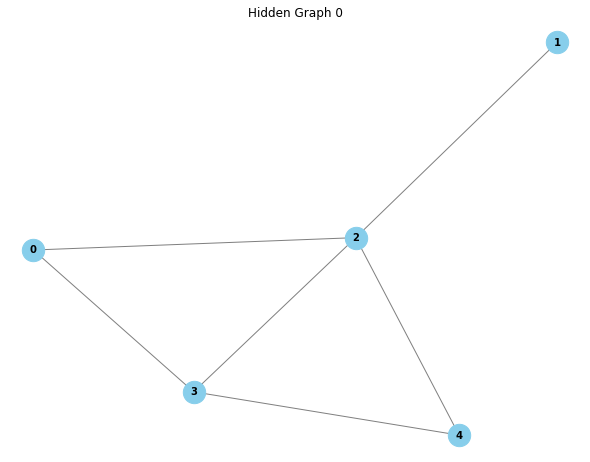

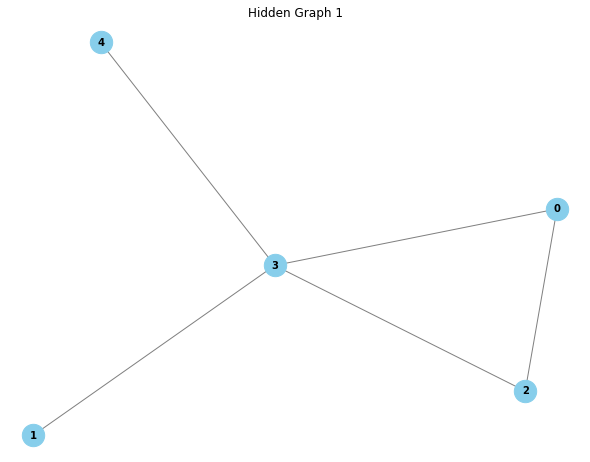

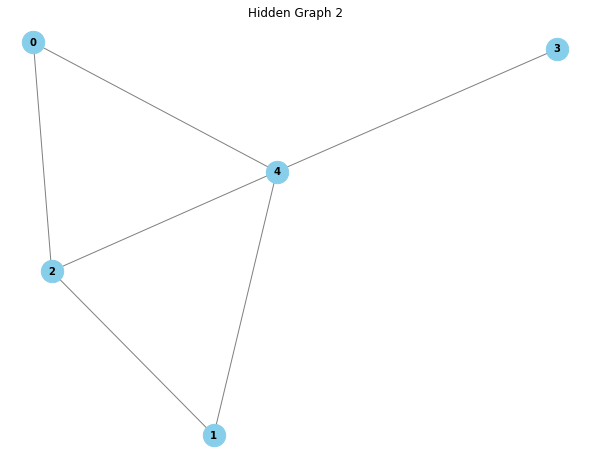

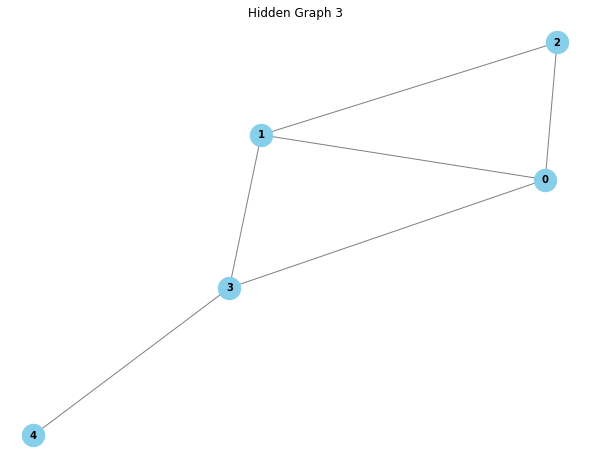

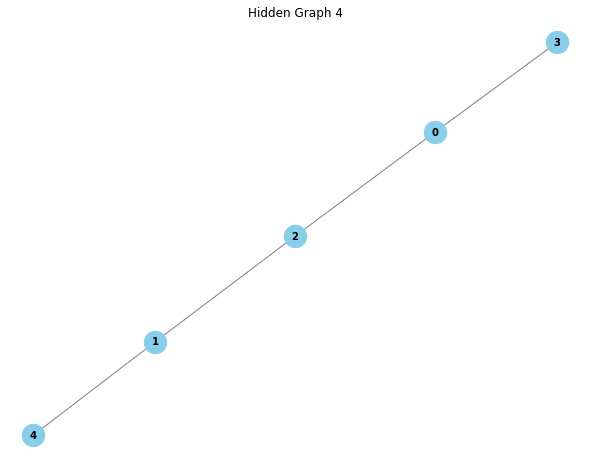

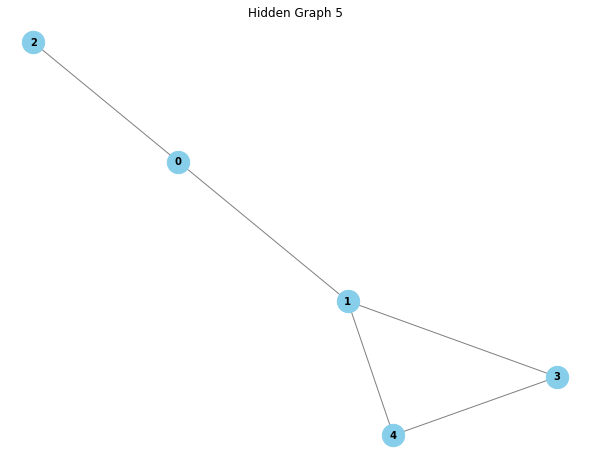

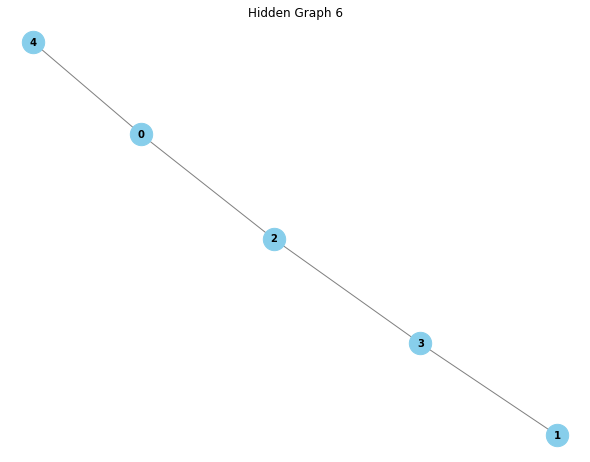

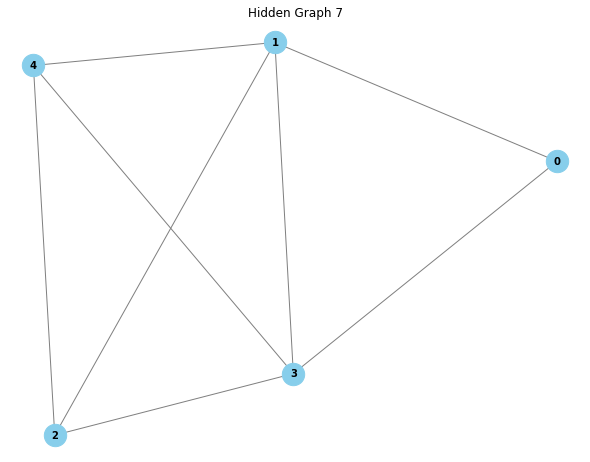

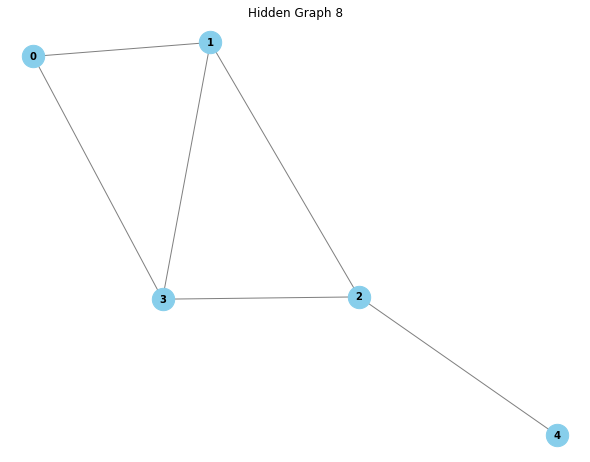

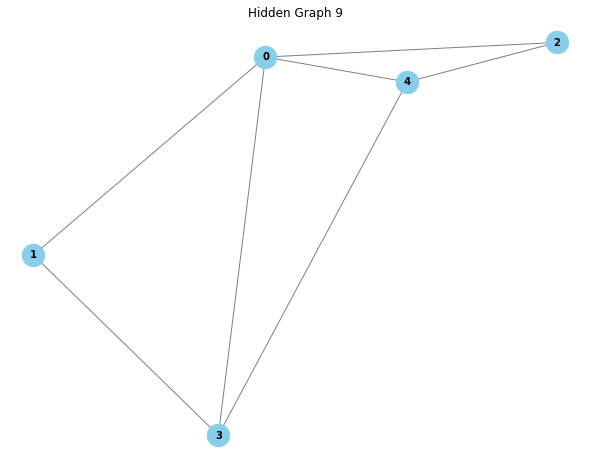

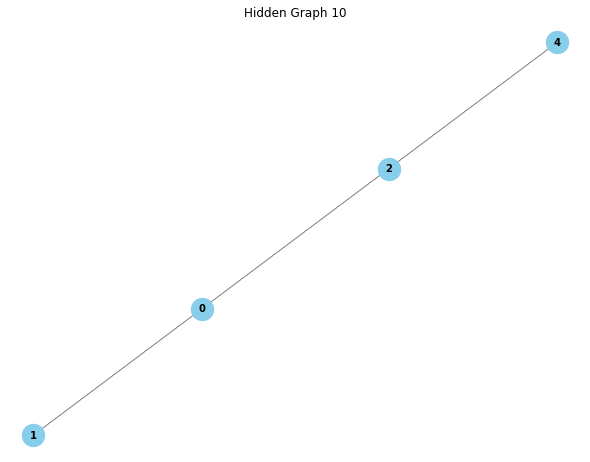

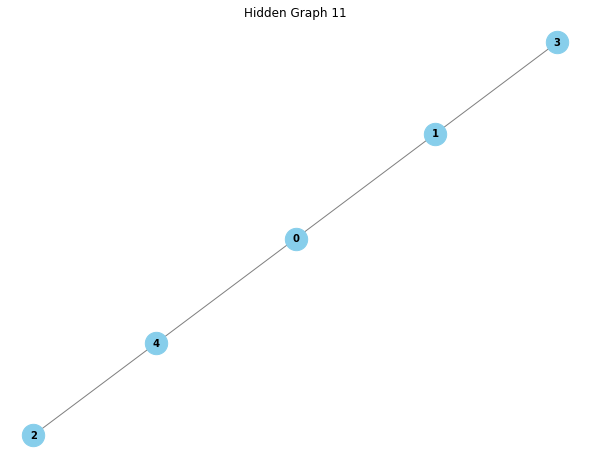

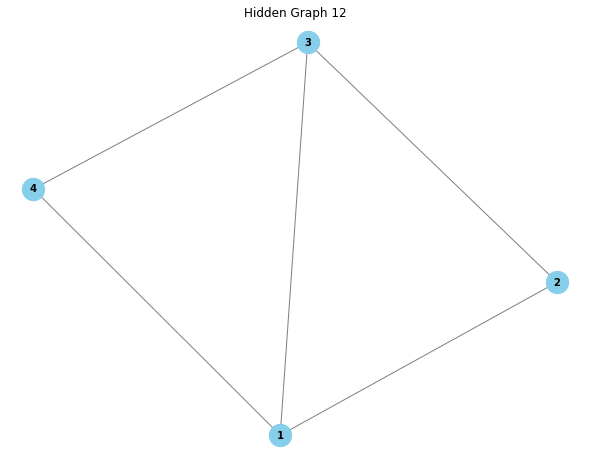

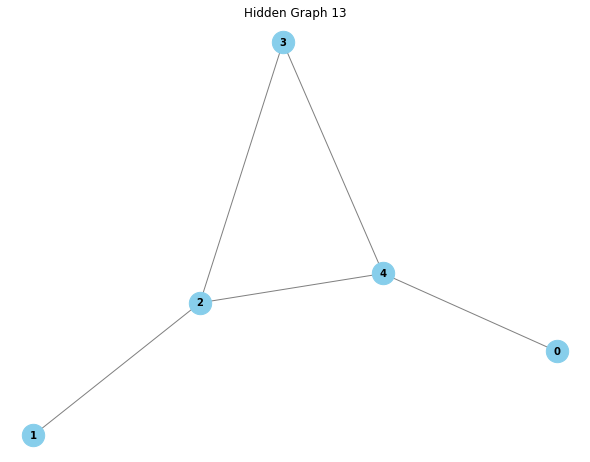

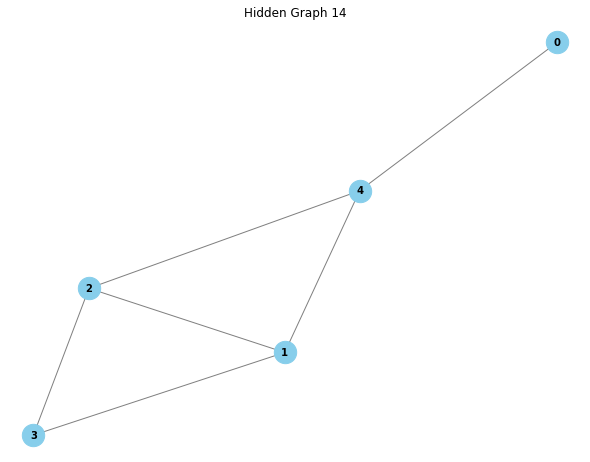

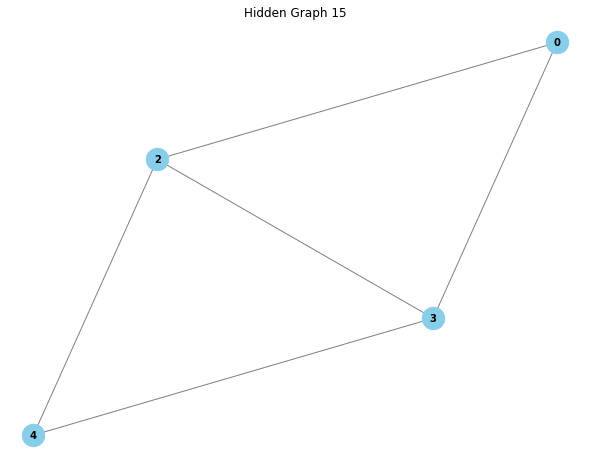

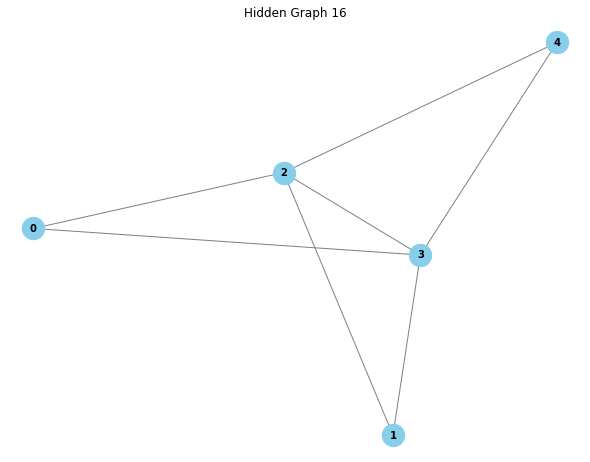

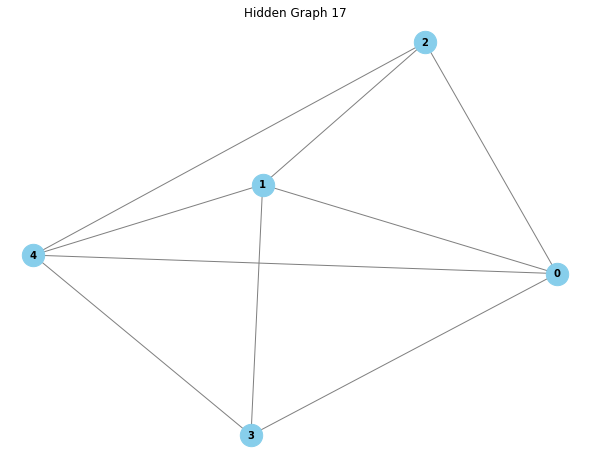

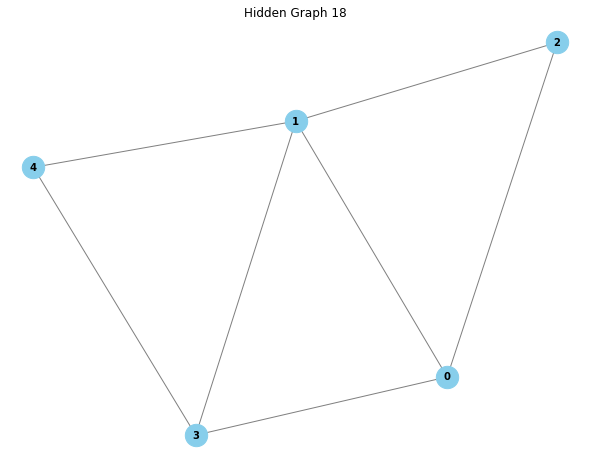

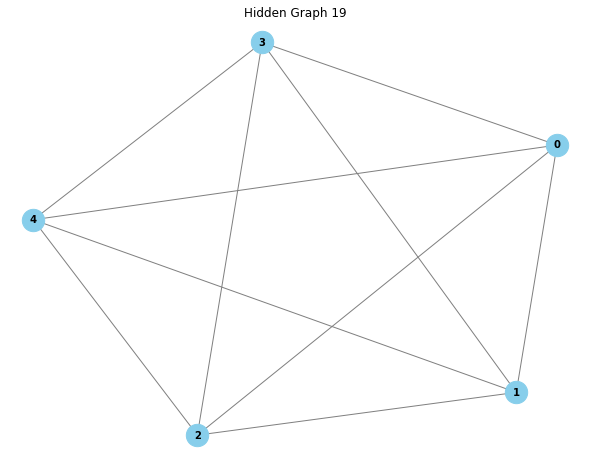

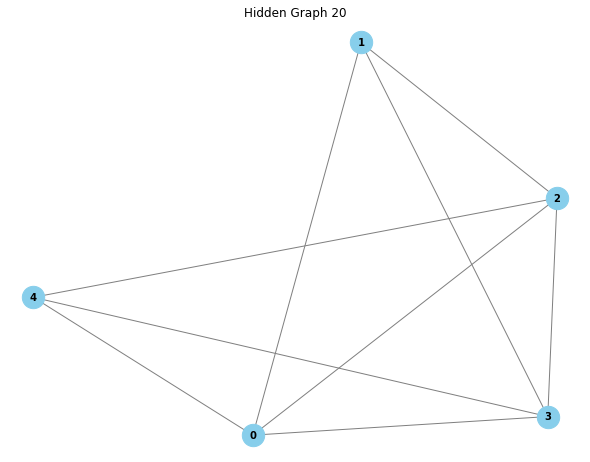

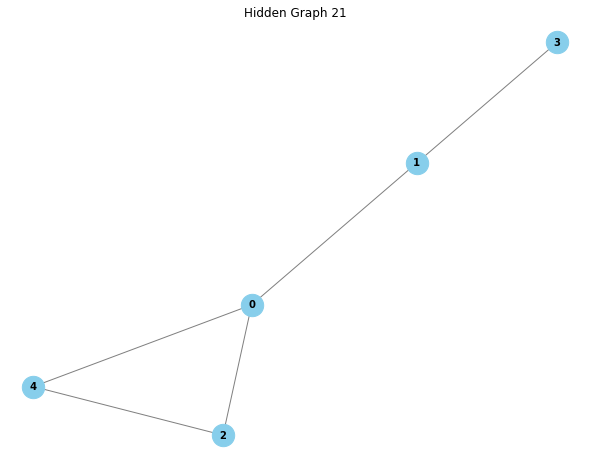

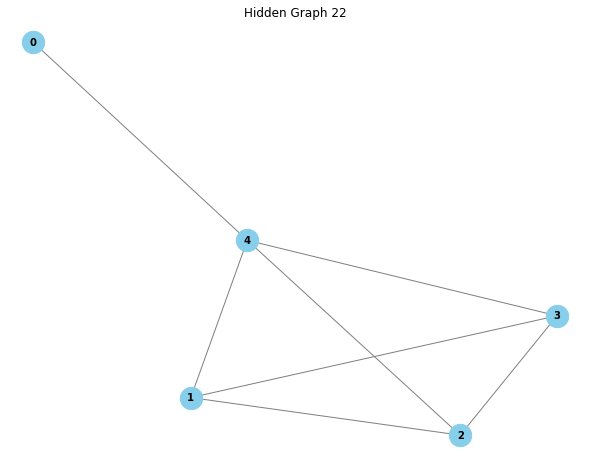

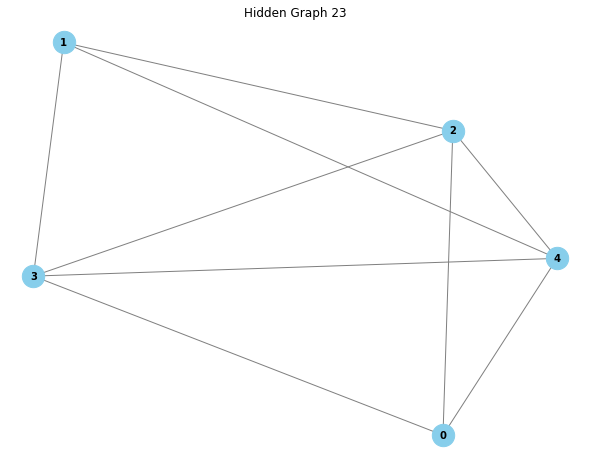

In [77]:
import matplotlib.pyplot as plt
import networkx as nx

# Assuming model is defined and adjacency lists are obtained as follows:
adjacency_lists = model.build_hidden_graph_tree()

# Draw the adjacency list as a graph using NetworkX and Matplotlib
for i, adj_list in enumerate(adjacency_lists):
    G = nx.Graph()  # Create a new graph
    # Add edges to the graph based on the adjacency list
    for node, neighbors in adj_list.items():
        for neighbor in neighbors:
            G.add_edge(node, neighbor)

    # Draw the graph
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G)  # Positioning the nodes using the spring layout
    nx.draw(G, pos, with_labels=True, node_size=500, node_color='skyblue', font_size=10, font_weight='bold', edge_color='gray')
    plt.title(f"Hidden Graph {i}")
    plt.show()
